#COVID-19 Prediction

Since late 2019, the world been in health crisis because of the COVID-19 pandemic. In fact, using Medical Imagery has proved to be efficient in detecting Covid-19 Infection. These Medical Imaging include: X-ray, CT-scans and Ultrasounds. The use of CT-scans is not only limited to the detection of COVID-19 cases, but they can also be used for other important tasks such quantifying the infection and monitoring the evolution of the disease, which can help in treatment and save the patient’s life. In this challenge, the participants will use a dataset labelled by two expert radiologists, who estimated the Covid-19 infection, to train and validate their approaches. In the testing phase, participants will test their approaches using a test dataset collected from various CT-scanners and recording settings.

- In your google drive, create a folder called "DL_Project"
- Place this .ipynb notebook in that folder
- Upload the training & val dataset zip in that folder
- Only have to do this once the very first time you are setting up project

In [ ]:
## mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## if you haven't unzipped training data
#!unzip "drive/MyDrive/DL_Project/Train.zip" -d  "drive/MyDrive/DL_Project/"

In [ ]:
## if you haven't unzipped val data
#!unzip "drive/MyDrive/DL_Project/Val Blind.zip" -d  "drive/MyDrive/DL_Project/"

##Challenge Dataset:

The challenge has three sets: Train, Val, and Test, and we will only work with the Train set and Val set (unlabeled). 

The Train set is obtained from 132 CT-scans, from which 128 CT-scans has confirmed to have Covid-19 based on positive reverse transcription polymerase chain reaction (RT-PCR) and CT scan manifestations identified by two experienced thoracic radiologists. The rest four CT-scans have not any infection type (Healthy). The Val set is obtained from 57 CT-scans, from which 55 CT-scans has confirmed to have Covid-19 based on positive reverse transcription polymerase chain reaction (RT-PCR) and CT scan manifestations identified by two experienced thoracic radiologists. The rest two CT-scans have not any infection type (Healthy).

The Train split has two files: Images (Slices) Folder and Labeling Folder ('.csv' file) that contains the labels for each Slice (Image)

    Train Set
    ├── Slices Folder 
    │      ├ Image_0000.png
    │      ├ Image_0001.png
    │      ├ ...
    |      └ Image_3053.png
    ├── Labeling Folder
    │   └── Train.csv
    │         ├ Slice_Name        Covid-19_percentage  Subject    
    │         ├ Image_0000.png    0.0                  0
    │         ├ Image_0001.png    0.0                  0
    │         ├ ...               ...                  ..
    │         └ Image_3053.png    40.0	               131
    └── 

The Validation split has one file contains the slices images, which will be used to predict the Covid-19 infection percentage. These prediction should be saved as '.csv' file and submitted to the Codalab (https://competitions.codalab.org/competitions/35575) to evaluation the performance:

    Val Set
    ├── Slices Folder 
    │      ├ Image_0000.png
    │      ├ Image_0001.png
    │      ├ ...
     |      └ Image_1300.png
    └── 

## Deliverables

In the Validation phase, each team should submit the predictions of the validation data as 'predictions.csv' file, which contains the names of the slice images in the first column and the corresponding Covid-19 infection percentage estimation in the second column. **This file should be compressed as 'predictions.zip' file and submitted to CodaLab**.

In order to have access to the leader board, you must do the following:
- Participation in the Competition: Each team should request to participate in the competition on the CodaLab platform (https://competitions.codalab.org/competitions/35575) with specifying the team name, members, emails and affiliations. The team informations can be send to: faresbougourzi@gmail.com

    predictions.zip
    ├── predictions.csv
    │      ├ Image_0000.png    Pr0            
    │      ├ Image_0001.png    Pr1             
    │      ├ ...               ...              
    │      └ Image_1300.png    Pr1300	        
    └──   

## Evaluation

The evaluation metrics are: **Mean Absolute Error (MAE), Pearson Correlation coefficient (PC) and Root Mean Square Error (RMSE)**. The most important Evaluation Criterion is the **MAE**. In the event of two or more competitors achieve the same MAE, the PC and the RMSE are considered as the tie-breaker.

## Custom Dataset Class

In [ ]:
## preprocess data
## create custom data class

import os
import torch
import pandas as pd
from skimage import io, transform

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from PIL import Image
import glob

class CovidDataset(Dataset):
    """Covid CT dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        ## you can apply custom transformation on the image for data augmentation
        self.transform = transform

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.label_data.iloc[idx, 0])
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)
        p = self.label_data.iloc[idx, 1]
        subject_num = self.label_data.iloc[idx, 2]
        sample = {'image': image, 'percentage': p, 'subject': subject_num, 'img_name':img_name}

        # should be only applied on image, not percentage or subject #
        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
class CovidTestDataset(Dataset):
    """Covid CT TEST dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.image_list = []
        for filename in glob.glob(self.root_dir+"/*.png"): #assuming png
          self.image_list.append(filename)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_list[idx]
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)
        sample = {'image': image, 'img_name':img_name}

        return sample

In [ ]:
import torchvision
covid_dataset_train_val = CovidDataset(csv_file='drive/MyDrive/DL_Project/Train.csv',
                                    root_dir='drive/MyDrive/DL_Project/Train'
                                    #, transform = transforms.Compose([
                                    #           Rescale(256),
                                    #           RandomCrop(224),
                                    #           ToTensor()
                                    #       ])
                                    )

covid_dataset_test = CovidTestDataset(root_dir='drive/MyDrive/DL_Project/Val')

0 torch.Size([3, 512, 512]) 0.0 0
1 torch.Size([3, 512, 512]) 0.0 0
2 torch.Size([3, 512, 512]) 0.0 0
3 torch.Size([3, 512, 512]) 0.0 0


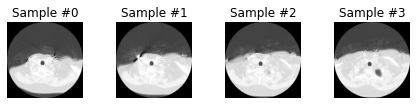

In [ ]:
## plot training example
for i in range(len(covid_dataset_train_val)):
    sample = covid_dataset_train_val[i]
    print(i, sample['image'].shape, sample['percentage'], sample['subject'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

0 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0304.png
1 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0303.png
2 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0301.png
3 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0302.png


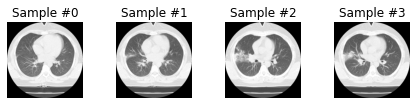

In [ ]:
## plot test examples
for i in range(len(covid_dataset_test)):
    sample = covid_dataset_test[i]
    print(i, sample['image'].shape, sample['img_name'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

##Split given train set to train & val set

In [ ]:
## split given train set to train & val set

#dataloader = DataLoader(covid_dataset, batch_size=4, shuffle=True, num_workers=0)
print(len(covid_dataset_train_val))
train_size = int(0.7 * len(covid_dataset_train_val))
val_size = len(covid_dataset_train_val) - train_size
print(train_size, val_size)
train_dataset, val_dataset = torch.utils.data.random_split(covid_dataset_train_val, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

## test set
test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)

3053
2137 916


## Import pretrained models library

In [ ]:
## use imagenet pretrained model
## let's start with resnet34
!pip install pretrainedmodels

## Use CUDA to speed up training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Create Baseline Model

In [ ]:
import pretrainedmodels
#For model building
import torch
from torch import nn, optim
import torchvision
from torch.nn import functional as F

class CNN1(nn.Module):
    def __init__(self, pretrained=True):
        super(CNN1, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(512, 128, (5,5), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        #print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        return label

In [ ]:
#Setting model and moving to device
model_CNN = CNN1(True).to(device)

criterion = nn.L1Loss()
#optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)

In [ ]:
def train_model(model, criterion, optimizer, n_epochs=20):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    for epoch in range(1, n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        # train the model #
        model.train()
        for batch_idx, sample_batched in enumerate(train_dataloader):
            # importing data and moving to GPU
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            output=model(image).reshape(-1)
            # calculate loss
            loss = criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            # back prop
            loss.backward()
            # grad
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        # validate the model #
        model.eval()
        for batch_idx, sample_batched in enumerate(val_dataloader):
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)  
            output = model(image).reshape(-1)
            # calculate loss
            loss=criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model, 'drive/MyDrive/DL_Project/model.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
    # return trained model
    return model

In [ ]:
model_conv=train_model(model_CNN, criterion, optimizer)

Epoch 1, Batch 1 loss: 16.197865
Epoch 1, Batch 101 loss: 15.668919
Epoch 1, Batch 201 loss: 17.372765
Epoch: 1 	Training Loss: 18.042931 	Validation Loss: 15.956521
Validation loss decreased (inf --> 15.956521).  Saving model ...
Epoch 2, Batch 1 loss: 27.124233
Epoch 2, Batch 101 loss: 17.747414
Epoch 2, Batch 201 loss: 17.060146
Epoch: 2 	Training Loss: 17.064001 	Validation Loss: 17.130402
Epoch 3, Batch 1 loss: 25.492989
Epoch 3, Batch 101 loss: 19.714798
Epoch 3, Batch 201 loss: 18.825893
Epoch: 3 	Training Loss: 18.166977 	Validation Loss: 16.622173
Epoch 4, Batch 1 loss: 23.506935
Epoch 4, Batch 101 loss: 18.805151
Epoch 4, Batch 201 loss: 17.981487
Epoch: 4 	Training Loss: 17.528385 	Validation Loss: 15.979118
Epoch 5, Batch 1 loss: 18.084160
Epoch 5, Batch 101 loss: 16.466932
Epoch 5, Batch 201 loss: 16.725460
Epoch: 5 	Training Loss: 16.867290 	Validation Loss: 15.671663
Validation loss decreased (15.956521 --> 15.671663).  Saving model ...
Epoch 6, Batch 1 loss: 18.497730
E

## Save result on Actual Val Data to csv File

In [ ]:
df = pd.DataFrame(columns=['image_name','output'])
for batch_idx, sample_batched in enumerate(test_dataloader):
    image= sample_batched['image'].to(device)
    img_name= sample_batched['img_name']
    output = model_conv(image).type(torch.LongTensor).reshape(-1)
    img_name = np.array(img_name).reshape(output.shape[0],1)
    o = output.cpu().data.numpy().reshape(output.shape[0],1)
    a = np.concatenate((img_name,o),axis=1)
    df = df.append(pd.DataFrame(a, columns=df.columns), ignore_index=True)
    

In [ ]:
#Extracting image name from the image path
df['image_name']=df['image_name'].str.split("/").str[-1]

In [ ]:
df.to_csv('drive/MyDrive/DL_Project/predictions.csv', index=False, header=False)

In [ ]:
df.head()

,image_name,output
0,Image_0866.png,6
1,Image_0547.png,6
2,Image_0301.png,6
3,Image_0860.png,6
4,Image_0395.png,6


## Points to note:

General Rules: Participants should estimate the percentage of Covid-19 infection from each slice using Machine Learning. **Only ImageNet's pre-trained models and Lung Nodule Segmentation models are allowed**. The use of external data or other pre-trained models is not allowed. The models must be trained using the training data and evaluated using the validation data.

##Things you can try:

- The dataset is not as big and especially negative covid images are very few.
It would be better to use k-fold cross validation rather than conventional splitting.
- How would you split image splices from the same patient subject into train & val set?
- How would the information on the patient (subject #) help your prediction?
- What kind of preprocessing/data augmentation method help your model? What kind of methods would actually make your model perform worse?
- What other different CNN architectures could you explore to acheive lower MAE?
- Explore different optimizers, loss combinations, etc
- Explore different regularization methods

This is no way an exhaustive list. You might get a better idea by reading relevant research papers. Good luck!